In [1454]:
import os
import glob
import numpy as np
import multiprocessing
import pandas as pd
import nibabel as nib
import scipy
import matplotlib
import seaborn as sns
import statsmodels
import matplotlib.pyplot as plt
from statsmodels.stats.multitest import multipletests, _ecdf as ecdf, fdrcorrection as fdrcorrection0, fdrcorrection_twostage
%matplotlib inline

In [1537]:
#preliminary housekeeping
home_dir = '/data/home/iballard/mag/'
subj_file = home_dir + 'subjects.txt'
subs = list(np.loadtxt(subj_file,'string'))
os.chdir(home_dir)
exp = 'mag-maxSV'
runs = map(str,range(1,5))
smoothing = 'smoothed'

In [1560]:
contrast = 'decision'
# rois = ['Cont','Attn'] #substrings that identify prefrontal ROIS

rois = ['_amfg',
        '_pmfg',
        '_fpc',
        '_ifg',
        '_psfs',
        '_asfs',
        '_ifs',
       '_ains']

In [1561]:
df = pd.DataFrame(columns=('sub','contrast','mask_vox','hemi','label','value'))

for sub in subs:
    cope = home_dir + '/analysis/' + exp + '/' + sub + '/ffx/epi/' + smoothing + '/' + contrast + '/cope1.nii.gz'
    cope = nib.load(cope).get_data()
    
    masks = glob.glob(home_dir + '/data/' + sub + '/masks/*.*nii.gz')
    masks = [m for m in masks if any(substring in m for substring in rois)]
#     masks = [m for m in masks if any(substring in m for substring in ['PFC','OFC'])]

    for m in masks:
        hemi = m.split('/')[-1].split('.')[0]
        label = m.split('/')[-1].split('.')[1]
        m = nib.load(m).get_data().astype(bool)
        num_voxels = m.sum()
        func_masked = cope[m]
        row = pd.DataFrame([dict(sub = sub, 
                                 contrast =contrast, 
                                 mask_vox = num_voxels, 
                                 hemi = hemi,
                                 label = label, 
                                 value = func_masked.mean()), ])
        df = df.append(row, ignore_index = True)

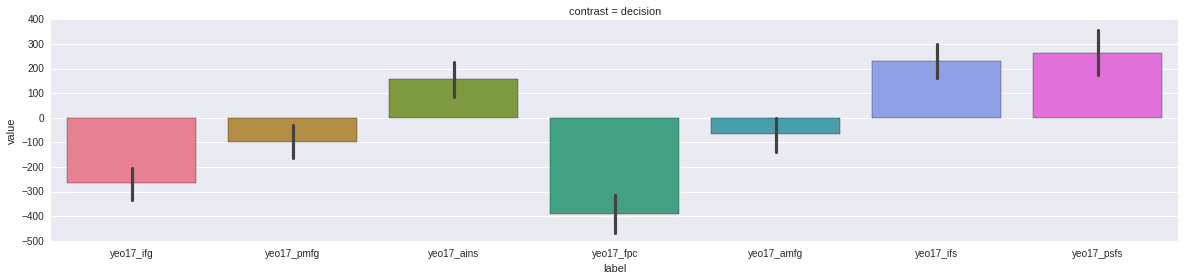

In [1562]:
sns.factorplot(x='label', y='value', col='contrast', 
               aspect=4, kind='bar', col_wrap=4,
               ci=68, palette='husl',
               units='sub', data=df)
plt.savefig('/home/iballard/Dropbox/mag_figs/' + contrast + '.png')

In [1563]:
results_df =pd.DataFrame(columns=('contrast','label','hemi','p_unc'))
for roi in set(df['label']):
    for hemi in ['lh','rh']:
        vals = df.ix[(df['label'] == roi) & (df['hemi'] == hemi),'value'].values
        t,p = scipy.stats.wilcoxon(vals)
        row = pd.DataFrame([dict(contrast = contrast, 
                                 label = roi,
                                 hemi = hemi,
                                p_unc = p), ])
        results_df = results_df.append(row, ignore_index = True)

results_df = results_df.dropna()
sig,pcorr = fdrcorrection0(results_df['p_unc'],.05)
results_df['p_corr'] = pcorr
results_df['sig'] = sig

# results_df

In [1564]:
results_df =pd.DataFrame(columns=('contrast','label','p_unc'))
for roi in set(df['label']):
    vals = df.ix[df['label'] == roi,'value'].values
    t,p = scipy.stats.wilcoxon(vals)
    row = pd.DataFrame([dict(contrast = contrast, 
                             label = roi,
                            p_unc = p), ])
    results_df = results_df.append(row, ignore_index = True)
sig,pcorr = fdrcorrection0(results_df['p_unc'],.05)
results_df['p_corr'] = pcorr
results_df['sig'] = sig

print results_df

   contrast       label     p_unc    p_corr    sig
0  decision   yeo17_ifg  0.000037  0.000129   True
1  decision   yeo17_fpc  0.000004  0.000031   True
2  decision  yeo17_amfg  0.293068  0.293068  False
3  decision  yeo17_ains  0.006837  0.009572   True
4  decision   yeo17_ifs  0.000199  0.000465   True
5  decision  yeo17_pmfg  0.020716  0.024169   True
6  decision  yeo17_psfs  0.001252  0.002191   True


In [1516]:
results_df[results_df['sig']]

,contrast,label,p_unc,p_corr,sig
1,high_minus_low,yeo17_fpc,0.002058,0.014406,True


In [1510]:
results_df[results_df['sig']]

,contrast,label,p_unc,p_corr,sig


In [1237]:
results_df[results_df['sig']]

,contrast,label,p_unc,p_corr,sig
26,high_minus_low_SV,17Networks_RH_SalVentAttnA_PrC,0.001341,0.024581,True
35,high_minus_low_SV,17Networks_DorsAttnB_PostC,0.000745,0.020485,True
41,high_minus_low_SV,17Networks_DorsAttnB_FEF,0.000248,0.013664,True
